In [7]:
import sys

sys.path.insert(1, '../..')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import csv
import ROOT
import time
%matplotlib inline 

Welcome to JupyROOT 6.24/02


In [8]:
import matplotlib.pyplot as plt
from matplotlib import cycler, patches

IPython_default = plt.rcParams.copy()
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

figsize = (4.5, 3)

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"

marker_size = 3
line_width = 0.5

colors = cycler('color', ['#EE6666', '#3388BB', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB', '#653700', '#F97306'])
plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle=colors)


In [9]:
def linear_voltage(r, V0, d):
    return V0*r/d

def non_linear_voltage(r, V0, d):
    return V0*(r/d)**2
    
def xsec(x, A, B):
    return (A*np.log(x) + B)/x

def poly(x,A,B,C,D):
    return A*x**3 + B*x**2 + C*x + D

def xsec_integrand(x, A, B):
    return (A*np.log(x) + B)

def chi2(y_obs, y_exp, y_err, Ndof):
    return np.sum(((y_obs - y_exp)/y_err)**2)/Ndof

In [10]:
d = 0.1   # distance from cathode to anode
V0 = 650  # PMT total voltage
e = 1.60217662e-19

In [11]:
V = (4*np.pi/3)*((0.0254*4)**3)
T = 293
k = 1.38064852e-23
V_0 = 588
d = 0.1
E_0 = 24.587
E_1 = V_0
x_0 = d*np.sqrt(E_0/V_0)
x_1 = d

$p_i(t) = \frac{DSART}{lV}p_et + \frac{2lSp_e}{\pi^2V}\sum^{\infty}_{n=1}\frac{\cos(n\pi)}{n^2}\bigg[1 - e^{\frac{-Dn^2\pi^2t}{l^2}}\bigg]$

In [44]:
def sumat(x, D, l, n_max):
    y = []
    for i in range(len(x)):
        y.append(0)
        for n in range(1, n_max):
            f = -(D * (n*np.pi)**2 * x[i])/(l**2)
            y[i] += np.cos(n*np.pi)*(np.exp( f ))/(n**2)
    return y

In [56]:
x = np.linspace(0,0.02*24*3600, 1000)
D = 7.74e-9  #cm2/s
l = 0.1
n_max = [10*(5**i) for i in range(6)]
ys = []
for n in n_max:
    ys.append(np.array(sumat(x,D,l,n)))

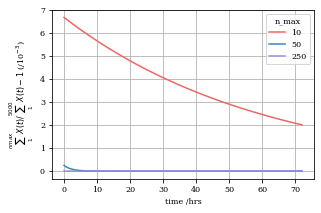

In [73]:
plt.figure(figsize=(4.5, 3), facecolor='white')
for i in range(3):
    plt.plot(x/(24),(ys[i]/ys[-1] - 1) / 1e-3,label='{}'.format(n_max[i]))
plt.legend(title = "n_max", loc='upper right')
# plt.xlim(0,0.02*3600)
# plt.yscale('log')
plt.xlabel('time /hrs')
plt.ylabel(r"$\sum_1^{nmax} X(t) / \sum_1^{5000} X(t) - 1 $ (/10$^{-3}$)")
# plt.ylabel(r"$x + 3$")
plt.tight_layout()
plt.savefig('/Users/williamquinn/Desktop/PMT_Project/summation.pdf')

In [3]:
file = ROOT.TFile("/Users/williamquinn/Desktop/SNEMO/200320_A1400_B1400_t0929_output.root")

In [4]:
file.ls()

TFile**		/Users/williamquinn/Desktop/SNEMO/200320_A1400_B1400_t0929_output.root	
 TFile*		/Users/williamquinn/Desktop/SNEMO/200320_A1400_B1400_t0929_output.root	
  KEY: TH1D	200320_GAO607_charge_spectrum_1400V;1	200320_GAO607_charge_spectrum_1400V
  KEY: TH1D	200320_GAO607_amplitude_spectrum_1400V;1	200320_GAO607_amplitude_spectrum_1400V
  KEY: TH1D	200320_GAO607_baseline_distribution_1400V;1	200320_GAO607_baseline_distribution_1400V
  KEY: TH1I	200320_GAO607_apulse_num_1400V;1	200320_GAO607_apulse_num_1400V
  KEY: TH1I	200320_GAO607_apulse_times_1400V;1	200320_GAO607_apulse_times_1400V
  KEY: TH1D	200320_GAO607_apulse_amplitudes_1400V;1	200320_GAO607_apulse_amplitudes_1400V
  KEY: TH1I	200320_GAO607_he_apulse_num_1400V;1	200320_GAO607_he_apulse_num_1400V
  KEY: TH1D	200320_GAO607_he_apulse_amplitudes_1400V;1	200320_GAO607_he_apulse_amplitudes_1400V
  KEY: TH1D	200320_GAO612_charge_spectrum_1400V;1	200320_GAO612_charge_spectrum_1400V
  KEY: TH1D	200320_GAO612_amplitude_spectrum_1400V;1

In [5]:
h_times = file.Get("200320_GAO607_apulse_times_1400V")

In [6]:
x = []
y = []
for i in range(1, int(h_times.GetNbinsX())+1):
    x.append(i-1)
    y.append(h_times.GetBinContent(i))

In [7]:
new_x = []
new_y = []
j = 0
temp = 0
bin_width = 50
for i in range(len(x)):
    j += 1
    temp += y[i]
    if j == bin_width:
        j = 0
        new_x.append(x[i])
        new_y.append(temp)
        temp = 0

In [10]:
template_file = ROOT.TFile("/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root")
template_file.ls()

TFile**		/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root	
 TFile*		/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root	
  KEY: TH1D	Template_Ch0;1	Template_Ch0
  KEY: TH1D	Template_Ch1;1	Template_Ch1


In [11]:
h_template = template_file.Get("Template_Ch0")
x = []
y = []

for i in range(1, h_template.GetNbinsX()+1):
    x.append(i-1)
    y.append(h_template.GetBinContent(i))
    print(i, h_template.GetBinContent(i))

1 -217.99499999999978
2 -589.9949999999998
3 -1531.9949999999994
4 -4323.994999999999
5 -10492.994999999999
6 -20545.994999999977
7 -30571.995
8 -35233.99500000005
9 -32111.995000000035
10 -23645.994999999988
11 -14178.994999999995
12 -7388.995000000001
13 -4541.995000000001
14 -4761.994999999999
15 -5972.995000000003
16 -6514.994999999999
17 -5681.995000000001
18 -4103.994999999999
19 -2570.994999999999
20 -1473.9949999999994


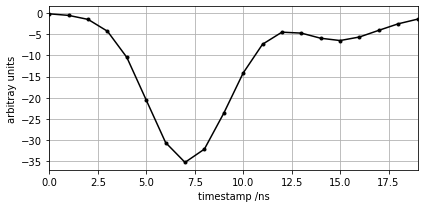

In [12]:
plt.figure(figsize=(6,3))
x = np.array(x)
y = np.array(y)
plt.plot(x,y/1000, 'k.-')
plt.ylabel('arbitray units')
plt.xlabel('timestamp /ns')
plt.grid()
plt.xlim(x[0], x[-1])
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/template.png")

In [30]:
def get_charge( waveform, baseline, peak_cell ):

    charge = 0.0
    resistance = 50.0
    integration = [0.1, 0.1]
    pre_trig = 500

    start,end = 0,0
    for i in range(pre_trig, peak_cell):
    
        if (waveform[i] - baseline) < (waveform[peak_cell] - baseline)*integration[0]:
            start = i
            break
        else:
            continue
    
    for i in range(peak_cell, waveform.size):
        if ( (waveform[i] - baseline) > (waveform[peak_cell] - baseline)*integration[1] ):
            end = i
            break
        else:
            continue

    for i in range(start,end):
        charge += (waveform[i] - baseline)
    return (-1.0)*charge/( resistance ), start, end

def get_charge_0( waveform, baseline, peak_cell ):

    charge = 0.0
    resistance = 50.0
    integration = [0.05, 0.05]
    pre_trig = 500
    start = peak_cell-15
    end= peak_cell+30
    for i in range(start,end):
        charge += (waveform[i] - baseline)
    return (-1.0)*charge/( resistance )

def get_baseline( waveform ):
    pre_trig = 500
    baseline = 0.0
    for i in range(0, pre_trig):
        baseline += waveform[i]
    
    return baseline/pre_trig


def get_peak_cell( waveform ):
    peak_cell = 0
    temp = waveform[0]
    for i in range(0, waveform.size):
        if ( waveform[i] < temp ):
            temp = waveform[i]
            peak_cell = i
    return peak_cell

def gaus(x, mu, sig, A):
    return A*np.exp(-(x - mu)**2/(2*(sig**2)))

def my_func(x, mu, sig, A, p1, p2, p3, p4):
    a = gaus(x, mu, sig, 7.08)
    b = gaus(x, mu*(1 + 72.144/975.651), sig*1.036, 1.84)
    c = gaus(x, mu*(1 + 84.154/975.651), sig*1.042, 0.44)
    d = p1*(np.exp(p2*x)/(1 + np.exp((x - p3)/p4)))  
    return A*(a+b+c) + d

def my_func_0(x, mu, sig, A):
    a = gaus(x, mu, sig, 7.08)
    b = gaus(x, mu*(1 + 72.144/975.651), sig*1.036, 1.84)
    c = gaus(x, mu*(1 + 84.154/975.651), sig*1.042, 0.44)
    return A*(a+b+c)
def comp(c, p1,p2,p3,p4):
    return p1*(np.exp(p2*(x))/(1 + np.exp((x - p3)/p4)))

In [13]:
canvas = ROOT.TCanvas()
h_template.Draw()
canvas.SaveAs("/Users/williamquinn/Desktop/test.png")

Info in <TCanvas::Print>: png file /Users/williamquinn/Desktop/test.png has been created


In [72]:
filename = "/Users/williamquinn/Desktop/PMT_Project/res_data_ch0/201216/A1000_B1000_t0918_Ch0.xml"
date = filename.split("/")[-2]
channel = filename.split("/")[-1].split("_")[-1].split(".")[0]
f = open(filename, 'r')
fl = f.readlines()
waveforms = []
charges = []
charges_0 = []
j = 0
time_ = time.time()
for i, line in enumerate(fl):
    if '<trace channel=' in line:
        waveform = np.array(line.split('>')[-1].split(' '), dtype=int)
        waveforms.append(waveform)
        j += 1
        
        peak_cell = get_peak_cell(waveform)
        if peak_cell > 700:
            continue
        baseline = get_baseline(waveform)
        # charge, start, end = get_charge(waveform, baseline, peak_cell)
        charge_0 = get_charge_0(waveform, baseline, peak_cell)
        # charges.append(charge)
        charges_0.append(charge_0)
    
        if j % 10000 == 0:
            temp = time.time()
            print(j, 'events step =',temp - time_, 's')
            time_ = temp

10000 events step = 21.16009497642517 s
20000 events step = 21.02176308631897 s
30000 events step = 20.899959087371826 s
40000 events step = 20.98722195625305 s
50000 events step = 21.582916021347046 s
60000 events step = 20.90380311012268 s
70000 events step = 21.36444067955017 s
80000 events step = 21.51638412475586 s
90000 events step = 21.22037386894226 s


0.25


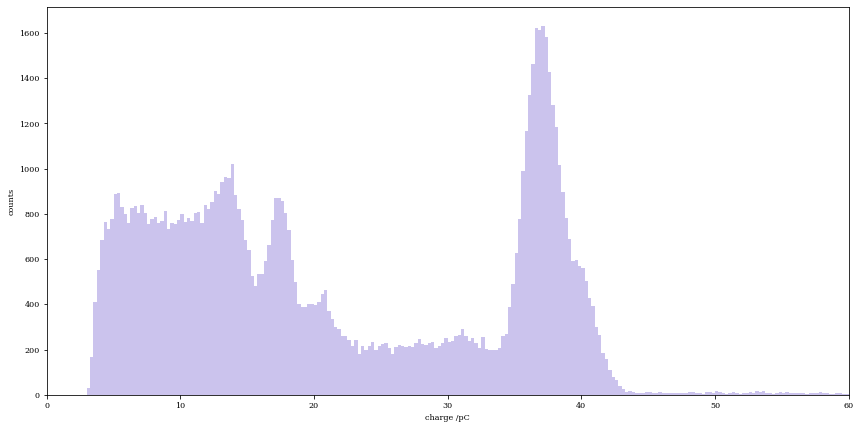

In [73]:
charges = np.array(charges)
charges_0 = np.array(charges_0)

max_charge = 60
min_charge = 0
n_bins = 240

freq, bin_edges = np.histogram(charges, bins=n_bins, range=[min_charge,max_charge])
bin_width = bin_edges[2] - bin_edges[1]
bin_centres = (bin_edges + bin_width/2)[:-1]

plt.figure(figsize=(12,6), facecolor='white')
#plt.bar(bin_centres, freq, width = bin_width, color='C1', alpha=0.5)

freq_0, bin_edges_0 = np.histogram(charges_0, bins=n_bins, range=[min_charge,max_charge])
bin_width_0 = bin_edges_0[2] - bin_edges_0[1]
print(bin_width)
bin_centres_0 = (bin_edges_0 + bin_width_0/2)[:-1]

plt.bar(bin_centres_0, freq_0, width = bin_width_0, color='C2', alpha=0.5)


plt.grid()
plt.xlabel('charge /pC')
plt.ylabel('counts')
plt.xlim(min_charge, max_charge)
plt.tight_layout()
#plt.savefig("/Users/williamquinn/Desktop/apulse_times_example.png")

36.89019536239083 1.2063594247711453 225.53742427071944 3.162562779228324
 FCN=72.7389 FROM MIGRAD    STATUS=CONVERGED     111 CALLS         112 TOTAL
                     EDM=1.31461e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            2.25537e+02   2.77720e+00   3.13393e-05   2.37349e-03
   2  mu           3.68902e+01   1.74413e-02   2.22078e-05   5.98566e-03
   3  sigma        1.20636e+00   1.80828e-02   1.90349e-05   9.20612e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: bi_spectrum
Warning in <TROOT::Append>: Replacing existing TH1: 201216 (Potential memory leak).


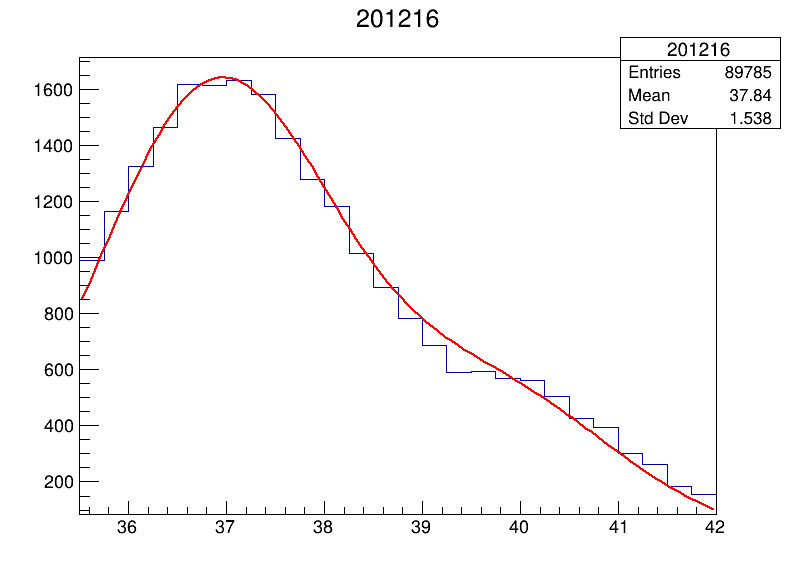

In [81]:
c = ROOT.TCanvas("bi_spectrum","Bi Spectrum",800,600)
lower = 35.5
higher = 42
low_bin = int(lower / bin_width_0)
high_bin = int(higher / bin_width_0)
hist = ROOT.TH1D(date, date, n_bins, min_charge, max_charge)

for i in range(len(charges_0)):
    hist.Fill(charges_0[i])
hist.GetXaxis().SetRangeUser(lower, higher)

fit = ROOT.TF1("fit",
                "[0]*"
                "(7.08*TMath::Gaus(x,[1],[2]) "
                " + 1.84*TMath::Gaus(x,[1]*(1 + 72.144/975.651),[2]*1.036) "
                " + 0.44*TMath::Gaus(x,[1]*(1 + 84.154/975.651),[2]*1.042)) ",
                lower, higher)

fit.SetParNames("A", "mu", "sigma")

fit.SetParLimits(0, 0, 400)
fit.SetParLimits(1, lower, higher)
fit.SetParLimits(2, 0.8, 10)
fit.SetParameters(319, (higher+lower)/2, 1.09)

hist.Fit("fit", "S", "", lower, higher)
hist.Draw()

c.Update()
c.Draw()

mu = fit.GetParameter(1)
mu_err = fit.GetParError(1)
sig = fit.GetParameter(2)
sig_err = fit.GetParError(2)
A = fit.GetParameter(0)
A_err = fit.GetParError(0)
chi = fit.GetChisquare()/fit.GetNDF()
print(mu, sig, A, chi)

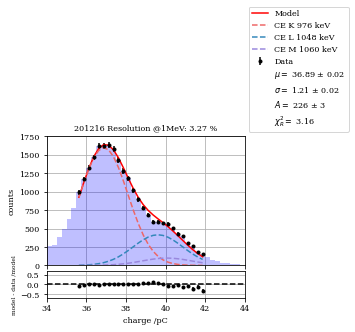

In [86]:
#PLOT
fig1 = plt.figure(figsize=(5, 3), facecolor='white')
#Plot Data-model
frame1=fig1.add_axes((.125,.3,.55,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.bar(bin_centres_0, freq_0, width = bin_width, color='b', alpha=0.25)
plt.errorbar(bin_centres_0[low_bin:high_bin], freq_0[low_bin:high_bin], yerr=np.sqrt(freq_0[low_bin:high_bin]), fmt='k.', label = 'Data')
plt.plot(bin_centres_0[low_bin:high_bin],
         my_func_0(bin_centres_0[low_bin:high_bin],mu, sig, A), 'r-',
         label = 'Model')
plt.plot(bin_centres_0[low_bin:high_bin], gaus(bin_centres_0[low_bin:high_bin], mu, sig, A*7.08), '--',
        label='CE K 976 keV')
plt.plot(bin_centres_0[low_bin:high_bin], gaus(bin_centres_0[low_bin:high_bin], mu*(1 + 72.144/975.651), sig*1.036, A*1.84), '--',
        label='CE L 1048 keV')
plt.plot(bin_centres_0[low_bin:high_bin], gaus(bin_centres_0[low_bin:high_bin], mu*(1 + 84.154/975.651), sig*1.042, A*0.44), '--',
        label='CE M 1060 keV')
frame1.set_xticklabels([])

handles, labels = plt.gca().get_legend_handles_labels()
patch = matplotlib.patches.Patch(color='white', label=r'$\mu =$ {:.2f} ± {:.2f}'.format(mu, mu_err))
patch_1 = matplotlib.patches.Patch(color='white', label=r'$\sigma =$ {:.2f} ± {:.2f}'.format(sig, sig_err)) 
patch_2 = matplotlib.patches.Patch(color='white', label=r'$A =$ {:.0f} ± {:.0f}'.format(A, A_err)) 
patch_3 = matplotlib.patches.Patch(color='white', label=r'$\chi^2_R =$ {:.2f}'.format(chi)) 
handles.extend([patch, patch_1, patch_2, patch_3])
plt.legend(handles=handles, bbox_to_anchor=(1.0, 1))


plt.ylabel('counts')
plt.xlim(34, 44)
plt.title(date + ' Resolution @1MeV: {:.2f} %'.format(sig/mu * 100))

#Residual plot
temp = (my_func_0(bin_centres_0[low_bin:high_bin],mu, sig, A) - freq_0[low_bin:high_bin])/my_func_0(bin_centres_0[low_bin:high_bin],mu, sig, A)
temp_err = np.sqrt(freq_0[low_bin:high_bin])/my_func_0(bin_centres_0[low_bin:high_bin],mu, sig, A)
frame2=fig1.add_axes((.125,.15,.55,.125))        
plt.errorbar(bin_centres_0[low_bin:high_bin], temp, yerr=temp_err, fmt='k.')
plt.xlim(34, 44)
plt.xlabel('charge /pC')
plt.ylim(-0.7, 0.7)
plt.ylabel('model - data /model', fontsize=6)
plt.axhline(0,ls = '--', color='black')
plt.savefig("/Users/williamquinn/Desktop/" + date + "_bi_spectrum_" + channel + ".pdf")

In [9]:
res = sig/mu
res_err = np.sqrt( (mu_err/mu)**2 + (sig_err/sig)**2 )
with open("/Users/williamquinn/Desktop/res_data_ch0/res_file_" + channel + ".csv", "a") as file:
    file.write("\n{},{},{},{},{},{},{},{}".format(date, mu, mu_err, sig, sig_err, res, res_err, chi))

In [6]:
channel = 'Ch0'
file = open("/Users/williamquinn/Desktop/PMT_Project/res_data_ch0/res_file_" + channel + ".csv", 'r')
fl = file.readlines()

res_0 = []
res_err_0 = []
date_string_0 = []

for i, line in enumerate(fl):
    line_list = line.split(",")
    try:
        res_0.append(float(line_list[5].strip()))
        res_err_0.append(float(line_list[6].strip()))
        date_string_0.append(int(line_list[0].strip()))
    except:
        continue
res_0 = np.array(res_0)*100
res_err_0 = np.array(res_err_0)*res_0

channel = 'Ch1'
file = open("/Users/williamquinn/Desktop/PMT_Project/res_data_ch0/res_file_" + channel + ".csv", 'r')
fl = file.readlines()

res_1 = []
res_err_1 = []
date_string_1 = []

for i, line in enumerate(fl):
    line_list = line.split(",")
    try:
        res_1.append(float(line_list[5].strip()))
        res_err_1.append(float(line_list[6].strip()))
        date_string_1.append(int(line_list[0].strip()))
    except:
        continue
res_1 = np.array(res_1)*100
res_err_1 = np.array(res_err_1)*res_1

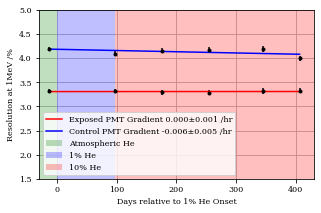

In [28]:
plt.figure(figsize=figsize, facecolor='white')
dates = process_date(np.array(date_string_0))
def linear(x, m, c):
    return m*x + c
popt_0, pcov_0 = curve_fit(f=linear, xdata = dates - np.average(dates), ydata=res_0, sigma=res_err_0,
                      p0=[0,0])
m_0 = popt_0[0] * 24
m_err_0 = np.sqrt(pcov_0[0,0]) * 24
c_0 = popt_0[1] - popt_0[0]*np.average(dates)
c_err_0 = np.sqrt( pcov_0[1, 1]**2 + np.average(dates)*pcov_0[0, 0]**2)

popt_1, pcov_1 = curve_fit(f=linear, xdata = dates - np.average(dates), ydata=res_1, sigma=res_err_1,
                      p0=[0,0])
m_1 = popt_1[0] * 24
m_err_1 = np.sqrt(pcov_1[0,0]) * 24
c_1 = popt_1[1] - popt_1[0]*np.average(dates)
c_err_1 = np.sqrt( pcov_1[1, 1]**2 + np.average(dates)*pcov_1[0, 0]**2)

s0 = r'Exposed PMT Gradient {:.3f}±{:.3f} '.format(m_0, m_err_0)
s1 = r'Control PMT Gradient {:.3f}±{:.3f} '.format(m_1, m_err_1)

plt.errorbar(dates, res_0, yerr=res_err_0, fmt='k.')
plt.plot(dates, linear(dates, popt_0[0], c_0), 'r-',
         label= s0 + r'/hr')


'''plt.plot(dates, linear(dates, popt_0[0], c_0), 'r-',
         label=r'Exposed PMT $y = ({:.0e}±{:.0e})x + ({:.4f}±{:.4f})$'.format(popt_0[0], np.sqrt(pcov_0[0, 0]), c_0, c_err_0))
'''
plt.errorbar(dates, res_1, yerr=res_err_1, fmt='k.')
'''plt.plot(dates, linear(dates, popt_1[0], c_1), 'b-',
         label=r'Control PMT $y = ({:.0e}±{:.0e})x + ({:.3f}±{:.3f})$'.format(popt_1[0], np.sqrt(pcov_1[0, 0]), c_1, c_err_1))
'''
plt.plot(dates, linear(dates, popt_1[0], c_1), 'b-',
         label= s1 + r'/hr')


plt.ylim(1.5,5)

plt.xlabel('Days relative to 1% He Onset')
plt.ylabel('Resolution at 1MeV /%')
plt.fill_between([-100, 0], [5 ,5], alpha=0.25,
                                 facecolor='green', label='Atmospheric He')
plt.fill_between([0, 98], [5 ,5], alpha=0.25,
                                 facecolor='blue', label='1% He')
plt.fill_between([98, 500], [5 ,5], alpha=0.25,
                                 facecolor='red', label='10% He')
plt.xlim(-30,430)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/res.pdf")
